In [1]:
import os
import random
import re
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer #, HashingVectorizer
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import MultinomialNB, GaussianNB
#from sklearn.linear_model import SGDlassifier(loss = ...) # loss='hinge'/'log'

from sklearn.model_selection import GridSearchCV

from joblib import dump, load

# Summary

### Bag od words with SVMs, Log-Regression, Random-Forest etc. on top 

* Build and test a preprocessing pipe:
    * Handle *LaTeX* formulas before count-vectorizatation and TFIDF transformation.
    * Test a handful of preprocessing parameters (inc. 2-grams, idf switched on/off, maximal document frequency) with a single untuned classifier.
* Test a handful of shallow multiclass classifiers with *macro-F1* as the objective, this time without broadly changing the preprocessing parameters:
* The grid-search in both step is (likely) performed on a fraction of the train data.
* Fit the tuned classifiers to the whole of train data.
* Collect the *macro-f1* scores obtained on the test data.
* ... Save the best fitted model to file

---

## Define the measure of success

In [3]:
# available scores
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

In [2]:
# my choice
scoring = "f1_macro"
average = "macro"

## Read in the two-column data frame (text + labels)

In [3]:
file = os.path.join("data", "bare_all.csv")

data = pd.read_csv(file, delimiter='\t')

In [4]:
# take a sample of records to play with
small_num = 10_000
sample = data[:small_num]

text = sample.text
label = sample.label

## Have a look at the data

In [7]:
print(f"No. all records in memory: {len(data)}")
with pd.option_context('display.max_colwidth', 120):
    display(data[:3])

No. all records in memory: 838804


,text,label
0,On the interplay between star formation and feedback in galaxy formation simulations. We investigate the star forma...,phys
1,Transversal Homotopy Monoids of Complex Projective Space. We will give a geometric description of the nth transvers...,math
2,Remarks on some typical assumptions in dynamo theory. Some concepts used in the theory of convection-driven dynamos...,phys


Abstracts of scientific papers tend to be written in a formal style, to not contain typos, nor direct citations, little references, ...

In [8]:
for _ in range(2):
    print(text.iloc[random.choice(range(len(text)))])
    print("---")

Inferring solutions of differential equations using noisy multi-fidelity data.  For more than two centuries, solutions of differential equations have been obtained either analytically or numerically based on typically well-behaved forcing and boundary conditions for well-posed problems. We are changing this paradigm in a fundamental way by establishing an interface between probabilistic machine learning and differential equations. We develop data-driven algorithms for general linear equations using Gaussian process priors tailored to the corresponding integro-differential operators. The only observables are scarce noisy multi-fidelity data for the forcing and solution that are not required to reside on the domain boundary. The resulting predictive posterior distributions quantify uncertainty and naturally lead to adaptive solution refinement via active learning. This general framework circumvents the tyranny of numerical discretization as well as the consistency and stability issues of

### One messy but informative kind of writing they have are LaTeX formulas (*\$...\$*)

In [9]:
text[6][:400]

'Riesz and frame systems generated by unitary actions of discrete groups.  We characterize orthonormal bases, Riesz bases and frames which arise from the action of a countable discrete group $\\Gamma$ on a single element $\\psi$ of a given Hilbert space $\\mathcal{H}$. As $\\Gamma$ might not be abelian, this is done in terms of a bracket map taking values in the $L^1$-space associated to the group von '

### We choose to either mask them with * \_latex\_ * or flag them by appending * \_latex\_ * in front of each such expression. 

In [10]:
# mask or flag LaTeX expression with a word ' _LATEX_ '

from sklearn.base import BaseEstimator, TransformerMixin

    # self.pattern = r"(\${1,2}[\s\w\d\\,\.=\(\)*{}/\[\]^;:'`<>|%&@\"!\?~#+-]*?\${1,2})"
    # why does it differ from  r'(\$.+?\$)' ?
    
class DeLaTeX(BaseEstimator, TransformerMixin):
    
    def __init__(self, behave=None, pattern=r"(\${1,2}[\s\w\d\\,\.=\(\)*{}/\[\]^;:'`<>|%&@\"!\?~#+-]*?\${1,2})", repl = ' _LATEX_ '):
        self.repl = ' _LATEX_ '
        self.pattern = pattern
        self.behave = behave
        
        if self.behave == 'mask':
            self.repl = ' _LATEX_ '
        elif self.behave == 'flag':
            self.repl = r' _LATEX_ \1'
        return None

    def fit(self, X, y=None):
        if not isinstance(X, pd.core.series.Series):
            raise TypeError("The data must be a pandas Series of strings")
        return self

    def transform(self, X):
        if self.behave:
            return X.str.replace(self.pattern, self.repl)
        return X
            

In [11]:
# from sklearn.utils.estimator_checks import check_estimator
# check_estimator(DeLaTeX)

In [12]:
delatex = DeLaTeX(behave = None)
delatex.transform(text[6:7]).iloc[0][:500]

'Riesz and frame systems generated by unitary actions of discrete groups.  We characterize orthonormal bases, Riesz bases and frames which arise from the action of a countable discrete group $\\Gamma$ on a single element $\\psi$ of a given Hilbert space $\\mathcal{H}$. As $\\Gamma$ might not be abelian, this is done in terms of a bracket map taking values in the $L^1$-space associated to the group von Neumann algebra of $\\Gamma$. Our result generalizes recent work for LCA groups. In many cases, the b'

In [13]:
delatex = DeLaTeX(behave = 'mask')
delatex.transform(text[6:7]).iloc[0][:500]

'Riesz and frame systems generated by unitary actions of discrete groups.  We characterize orthonormal bases, Riesz bases and frames which arise from the action of a countable discrete group  _LATEX_  on a single element  _LATEX_  of a given Hilbert space  _LATEX_ . As  _LATEX_  might not be abelian, this is done in terms of a bracket map taking values in the  _LATEX_ -space associated to the group von Neumann algebra of  _LATEX_ . Our result generalizes recent work for LCA groups. In many cases,'

In [14]:
delatex = DeLaTeX(behave = 'flag')
delatex.transform(text[6:7]).iloc[0][:500]

'Riesz and frame systems generated by unitary actions of discrete groups.  We characterize orthonormal bases, Riesz bases and frames which arise from the action of a countable discrete group  _LATEX_ $\\Gamma$ on a single element  _LATEX_ $\\psi$ of a given Hilbert space  _LATEX_ $\\mathcal{H}$. As  _LATEX_ $\\Gamma$ might not be abelian, this is done in terms of a bracket map taking values in the  _LATEX_ $L^1$-space associated to the group von Neumann algebra of  _LATEX_ $\\Gamma$. Our result genera'

## Encode the labels

In [5]:
# 'cs' -> 0, ..., 'stat' -> 5

label_e = LabelEncoder()
y_train = label_e.fit_transform(label)

print(list(label_e.classes_))

#label_e.inverse_transform([0]) # array(['cs'], dtype=object)

['cs', 'math', 'phys', 'q-bio', 'q-fin', 'stat']


## Have a look at the most frequent words. Choose winners as the stop-words.
Take note of the rank of our '\_latex\_'

In [18]:
delatex = DeLaTeX(behave = 'flag')
count_v = CountVectorizer(strip_accents='unicode')
word_counts_train = count_v.fit_transform(delatex.fit_transform(text))
word_counts_train.shape

(100000, 122807)

In [19]:
sum_word_counts_train = word_counts_train.sum(axis=0)
sorted([(round(sum_word_counts_train[0, i],-3), word) for word, i in count_v.vocabulary_.items()],reverse=True)[:10]

[(1057000, 'the'),
 (670000, 'of'),
 (370000, 'and'),
 (332000, 'in'),
 (277000, 'to'),
 (213000, 'we'),
 (195000, 'is'),
 (181000, 'for'),
 (180000, '_latex_'),
 (142000, 'that')]

In [20]:
stopwords = ['the', 'of', 'and', 'in','to','we','is'] # 'for' seems already mathematical/computer-sciency

---

## Go step by step through an arbitrary pipeline 

In [24]:
text_train = text

In [22]:
delatex = DeLaTeX(behave='mask')
tex_text_train = delatex.fit_transform(text_train)

In [23]:
tfidf_v = TfidfVectorizer(use_idf=True, stop_words=stopwords, min_df = 2, max_df=0.8, strip_accents='unicode')
tfidf_scores_train = tfidf_v.fit_transform(tex_text_train)

In [24]:
lsvc = LinearSVC(C=1, class_weight='balanced')
lsvc.fit(tfidf_scores_train, y_train)

LinearSVC(C=1, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Ok, let's just have some fun first:

In [25]:
random_abstracts = pd.Series(["""
The Lack of A Priori Distinctions Between Learning Algorithms. This is the first of
two papers that use off-training set (OTS) error to investigate the assumption-free
relationship between learning algorithms. This first paper discusses the senses in
which there are no a priori distinctions between learning algorithms. (The second
paper discusses the senses in which there are such distinctions.) In this first paper
it is shown, loosely speaking, that for any two algorithms A and B, there are "as many"
targets (or priors over targets) for which A has lower expected OTS error than B as
vice versa, for loss functions like zero-one loss. In particular, this is true if A
is cross-validation and B is "anti-cross-validation'' (choose the learning algorithm
with largest cross-validation error). This paper ends with a discussion of the
implications of these results for computational learning theory. It is shown that one
cannot say: if empirical misclassification rate is low, the Vapnik-Chervonenkis
dimension of your generalizer is small, and the training set is large, then with high
probability your OTS error is small. Other implications for "membership queries"
algorithms and "punting" algorithms are also discussed.
""",
"""
X-rays quarks lepton scattering experiment field
""",
"""
genes DNA RNA sequencing protein species fenotype 
""",
"""
computer algorithm graph sorting depth first interface
""",
"""
novel intuitive proof of $\limit_{x\to 0} x = 0$ convergence fomula,
""",
"""
inflation resources market stock bonds derivatives
""",
"""
distribution Bayesian p value marginalization Monte Carlo
"""
])

label_e.inverse_transform(lsvc.predict(tfidf_v.transform(delatex.transform(random_abstracts ))))

array(['cs', 'phys', 'q-bio', 'cs', 'math', 'q-fin', 'stat'], dtype=object)

Looks promising :)
Here's the actual score on a test set:

In [26]:
text_test = data[small_num:2*small_num].text
y_test = label_e.transform(data[small_num:2*small_num].label)

In [27]:
predicted_y_test = lsvc.predict(tfidf_v.transform(delatex.transform(text_test)))

In [28]:
print("Macro F1:", f1_score(y_test, predicted_y_test, average="macro"))
print(classification_report(y_test, predicted_y_test, target_names=label_e.classes_))
print(confusion_matrix(y_test, predicted_y_test))

Macro F1: 0.7783206076010205
              precision    recall  f1-score   support

          cs       0.84      0.88      0.86     13162
        math       0.89      0.91      0.90     23035
        phys       0.98      0.96      0.97     60193
       q-bio       0.63      0.64      0.64      1241
       q-fin       0.76      0.75      0.75       601
        stat       0.55      0.56      0.56      1768

   micro avg       0.92      0.92      0.92    100000
   macro avg       0.77      0.78      0.78    100000
weighted avg       0.93      0.92      0.92    100000

[[11581   868   299   104    19   291]
 [  953 20849   775    79    65   314]
 [  670  1382 57736   254    37   114]
 [  137    45   184   799     1    75]
 [   48    62    25     0   448    18]
 [  466   189    63    33    20   997]]


"By definition a confusion matrix $C$ is such that $C_{ij}$ is equal to the number of observations known to be in group $i$ but predicted to be in group $j$." https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

Having trained on a fraction of all records with an untuned Linear SVM, we have reached ~0.78 macro-F1 (out of sample) pulled down by poor performomance on classification wrt rarer classes. E.g. many *cs* and *math* are confused with *stat* (and vice versa), and similarly for *q-bio* and *physics*. This is actually sensible.

---

## Grid searching by hand through preprocessing params with Linear SVM Classifiers

In [21]:
pipe = []
pipe.append(( 'delatex', DeLaTeX(behave='mask') ))
pipe.append(( 'tfidf_v', TfidfVectorizer(analyzer = 'word', strip_accents='unicode', min_df = 2)  ))
pipe.append(( 'LinearSVC', LinearSVC(C=1, penalty='l2', class_weight='balanced')  ))

In [22]:
params = {
    'delatex__behave': ['mask', None],
    'tfidf_v__stop_words': [stopwords, None],
    'tfidf_v__ngram_range': [(1, 1), (1,2)],
    'tfidf_v__use_idf': [True, False],
    'tfidf_v__max_df': [0.6, 0.75, 0.9],
}
params['LinearSVC' + '__' + 'C'] = [0.2, 2]
params

{'delatex__behave': ['mask', None],
 'tfidf_v__stop_words': [['the', 'of', 'and', 'in', 'to', 'we', 'is'], None],
 'tfidf_v__ngram_range': [(1, 1), (1, 2)],
 'tfidf_v__use_idf': [True, False],
 'tfidf_v__max_df': [0.6, 0.75, 0.9],
 'LinearSVC__C': [0.2, 2]}

In [26]:
text_train = text

In [28]:
# LONG WAIT

# there's some bug with njobs different than 1 because of the delatex in the pipe
# may be related to the fact that check_estimator(DeLaTeX) raises an error due to DeLaTeX using the pandas' vectorized str method 

grid_s = GridSearchCV(Pipeline(pipe), params, cv=4, scoring=scoring, iid=False, return_train_score=True, n_jobs=1, refit=False, verbose=1)
grid_s.fit(text_train, y_train)

Fitting 4 folds for each of 96 candidates, totalling 384 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 384 out of 384 | elapsed: 258.8min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('delatex', DeLaTeX(behave='mask',
    pattern='(\\${1,2}[\\s\\w\\d\\\\,\\.=\\(\\)*{}/\\[\\]^;:\'`<>|%&@\\"!\\?~#+-]*?\\${1,2})',
    repl=' _LATEX_ ')), ('tfidf_v', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', ...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'delatex__behave': ['mask', None], 'tfidf_v__stop_words': [['the', 'of', 'and', 'in', 'to', 'we', 'is'], None], 'tfidf_v__ngram_range': [(1, 1), (1, 2)], 'tfidf_v__use_idf': [True, False], 'tfidf_v__max_df': [0.6, 0.75, 0.9], 'LinearSVC__C': [0.2, 2]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score=True,
       scoring='f1_macro', verbose=1)

In [29]:
grid_s.best_score_

0.7912419492069807

In [30]:
grid_s.best_params_

{'LinearSVC__C': 0.2,
 'delatex__behave': 'mask',
 'tfidf_v__max_df': 0.6,
 'tfidf_v__ngram_range': (1, 2),
 'tfidf_v__stop_words': None,
 'tfidf_v__use_idf': True}

In [31]:
grid_cv_results = pd.DataFrame(grid_s.cv_results_)
cols = ['param_' + param for param in params.keys()] + ['mean_test_score']
results_df = grid_cv_results[cols].sort_values(by=['mean_test_score','param_delatex__behave','param_tfidf_v__max_df'], ascending=False)

In [37]:
results_df[(results_df.param_LinearSVC__C == 0.2) & (results_df.param_tfidf_v__ngram_range==(1,2))][:10]

,param_delatex__behave,param_tfidf_v__stop_words,param_tfidf_v__ngram_range,param_tfidf_v__use_idf,param_tfidf_v__max_df,param_LinearSVC__C,mean_test_score
6,mask,None,"(1, 2)",True,0.6,0.2,0.791242
30,None,None,"(1, 2)",True,0.6,0.2,0.791209
38,None,None,"(1, 2)",True,0.75,0.2,0.790569
46,None,None,"(1, 2)",True,0.9,0.2,0.790383
14,mask,None,"(1, 2)",True,0.75,0.2,0.790162
22,mask,None,"(1, 2)",True,0.9,0.2,0.789770
28,None,"[the, of, and, in, to, we, is]","(1, 2)",True,0.6,0.2,0.788460
4,mask,"[the, of, and, in, to, we, is]","(1, 2)",True,0.6,0.2,0.788429
44,None,"[the, of, and, in, to, we, is]","(1, 2)",True,0.9,0.2,0.788314
36,None,"[the, of, and, in, to, we, is]","(1, 2)",True,0.75,0.2,0.788314


In [41]:
results_df[(results_df.param_LinearSVC__C == 0.2) & (results_df.param_tfidf_v__ngram_range==(1,2))][-10:]

,param_delatex__behave,param_tfidf_v__stop_words,param_tfidf_v__ngram_range,param_tfidf_v__use_idf,param_tfidf_v__max_df,param_LinearSVC__C,mean_test_score
29,None,"[the, of, and, in, to, we, is]","(1, 2)",False,0.6,0.2,0.780536
21,mask,"[the, of, and, in, to, we, is]","(1, 2)",False,0.9,0.2,0.780056
13,mask,"[the, of, and, in, to, we, is]","(1, 2)",False,0.75,0.2,0.780056
7,mask,None,"(1, 2)",False,0.6,0.2,0.779726
47,None,None,"(1, 2)",False,0.9,0.2,0.779349
45,None,"[the, of, and, in, to, we, is]","(1, 2)",False,0.9,0.2,0.779298
37,None,"[the, of, and, in, to, we, is]","(1, 2)",False,0.75,0.2,0.779298
23,mask,None,"(1, 2)",False,0.9,0.2,0.779035
15,mask,None,"(1, 2)",False,0.75,0.2,0.778934
39,None,None,"(1, 2)",False,0.75,0.2,0.778753


In [42]:
results_df[(results_df.param_LinearSVC__C == 0.2) & (results_df.param_tfidf_v__ngram_range==(1,1))][:10]

,param_delatex__behave,param_tfidf_v__stop_words,param_tfidf_v__ngram_range,param_tfidf_v__use_idf,param_tfidf_v__max_df,param_LinearSVC__C,mean_test_score
40,None,"[the, of, and, in, to, we, is]","(1, 1)",True,0.9,0.2,0.783177
32,None,"[the, of, and, in, to, we, is]","(1, 1)",True,0.75,0.2,0.783177
34,None,None,"(1, 1)",True,0.75,0.2,0.783177
42,None,None,"(1, 1)",True,0.9,0.2,0.782992
24,None,"[the, of, and, in, to, we, is]","(1, 1)",True,0.6,0.2,0.782940
26,None,None,"(1, 1)",True,0.6,0.2,0.782940
16,mask,"[the, of, and, in, to, we, is]","(1, 1)",True,0.9,0.2,0.782872
8,mask,"[the, of, and, in, to, we, is]","(1, 1)",True,0.75,0.2,0.782872
10,mask,None,"(1, 1)",True,0.75,0.2,0.782872
0,mask,"[the, of, and, in, to, we, is]","(1, 1)",True,0.6,0.2,0.782364


In [39]:
results_df[(results_df.param_LinearSVC__C == 2) & (results_df.param_tfidf_v__ngram_range==(1,2))][:10]

,param_delatex__behave,param_tfidf_v__stop_words,param_tfidf_v__ngram_range,param_tfidf_v__use_idf,param_tfidf_v__max_df,param_LinearSVC__C,mean_test_score
54,mask,None,"(1, 2)",True,0.6,2,0.784678
70,mask,None,"(1, 2)",True,0.9,2,0.784561
62,mask,None,"(1, 2)",True,0.75,2,0.783827
94,None,None,"(1, 2)",True,0.9,2,0.783620
86,None,None,"(1, 2)",True,0.75,2,0.783560
78,None,None,"(1, 2)",True,0.6,2,0.783283
92,None,"[the, of, and, in, to, we, is]","(1, 2)",True,0.9,2,0.783071
84,None,"[the, of, and, in, to, we, is]","(1, 2)",True,0.75,2,0.783071
68,mask,"[the, of, and, in, to, we, is]","(1, 2)",True,0.9,2,0.783070
60,mask,"[the, of, and, in, to, we, is]","(1, 2)",True,0.75,2,0.783070


In [44]:
results_df[(results_df.param_LinearSVC__C == 2) & (results_df.param_tfidf_v__ngram_range==(1,1))][-10:]

,param_delatex__behave,param_tfidf_v__stop_words,param_tfidf_v__ngram_range,param_tfidf_v__use_idf,param_tfidf_v__max_df,param_LinearSVC__C,mean_test_score
83,None,None,"(1, 1)",False,0.75,2,0.768993
64,mask,"[the, of, and, in, to, we, is]","(1, 1)",True,0.9,2,0.768403
56,mask,"[the, of, and, in, to, we, is]","(1, 1)",True,0.75,2,0.768403
58,mask,None,"(1, 1)",True,0.75,2,0.768403
72,None,"[the, of, and, in, to, we, is]","(1, 1)",True,0.6,2,0.768203
74,None,None,"(1, 1)",True,0.6,2,0.768203
48,mask,"[the, of, and, in, to, we, is]","(1, 1)",True,0.6,2,0.767866
50,mask,None,"(1, 1)",True,0.6,2,0.767866
73,None,"[the, of, and, in, to, we, is]","(1, 1)",False,0.6,2,0.767772
75,None,None,"(1, 1)",False,0.6,2,0.767772


With regards to our preprocessing steps:
    * By and large the search was performed over unimportant parameters.
    * The most important ones (at the level of gaining 0.8 percentage points), aside from the model's *C*, were: using (1,2)-word-grams rather than 1-word-grams and using IDFs over not using it.
    * The influence of max_df is small and not very consistent.
    * Our DeLaTeX behavior and stopwords have no significant effect.
   
In light of the above we will stick to:
    * no DeLaTeX
    * no stop-words
    * (1,2)-grams
    * using IDFs
    * no max_df limit (meaning the default =1.0)

---

## Automated GridSearchCV for multiple classifiers

In [6]:
text_train = text

### Helper functions

In [7]:
def build_clf(name, model):
    pipe = []
    #pipe.append(( 'delatex', DeLaTeX(behave='flag') ))
    pipe.append(( 'tfidf_v', TfidfVectorizer(use_idf=True, strip_accents='unicode', min_df = 2, ngram_range=(1,2))  ))
    pipe.append(( name, model  ))
    
    return Pipeline(pipe)

In [8]:
def build_pipe_params(name, model_params):
    params = {
        #'delatex__behave': [None],  # (bug) switch off in order to use n_jobs in GridSearchCV
        #'tfidf_v__ngram_range': [(1, 1), (1,2)],
        #'tfidf_v__use_idf': [True, False],
        #'tfidf_v__max_df': [0.8, 1.0],
    }
    for (param_name, range_) in model_params:
        params[name + '__' + param_name] = range_
        
    return params

### Specify models with grid of parametrs and run the GridSearchCV, cv=4 (stratified by default)

In [13]:
models = {
    
#     'rbfSVC': [SVC(class_weight='balanced', gamma='scale'),
#             [( 'C', [0.04, 0.2, 1, 5] )]
#            ],
    'LogReg': [LogisticRegression(class_weight='balanced', solver='lbfgs', multi_class='multinomial', max_iter=500),
                  [( 'C', [0.04, 0.2, 1, 5] ), ('multi_class', ['multinomial','ovr'])]
                 ],
    'RndFClf': [RandomForestClassifier(class_weight='balanced', n_estimators=300),
                 [('max_depth', [10, 20, 30]) , ('min_samples_leaf', [1E-5, 1E-4, 1E-3])]
                ],
    'LinSVC': [LinearSVC(class_weight='balanced'),
                  [( 'C', [0.04, 0.2, 1, 5] )]
                 ],
    'MultNB': [MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None),
                [('alpha', [0.01, 0.1, 1])]
               ],
    'NearCen': [NearestCentroid(),
                [('metric', ['euclidean','manhattan'])]
               ]
}

In [18]:
# GRID-SEARCH

# collect the best_params for the models
results = {}

for name, (model, model_params) in models.items():
    
    print(name)
    pipe = build_clf(name, model)
    params = build_pipe_params(name, model_params)
    
    grid_s = GridSearchCV(pipe, params, cv=4, scoring=scoring, iid=False, return_train_score=True, n_jobs=3, refit=False, verbose=1)
    grid_s.fit(text_train, y_train)
    
    print(grid_s.best_score_, "\n")
    results[name] = [grid_s.best_params_, grid_s.best_score_, grid_s.cv_results_]

    
# store the best_params in the models dict
for name, result in results.items():
    
    best_params = result[0]    
    models[name].append(best_params)

LogReg
Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  32 out of  32 | elapsed:  3.0min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


0.7220762959521979 

RndFClf
Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=3)]: Done  36 out of  36 | elapsed:  2.7min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


0.6220591350084321 

LinSVC
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=3)]: Done  16 out of  16 | elapsed:   39.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


0.7018498133838 

MultNB
Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:   25.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


0.6140310893111534 

NearCen
Fitting 4 folds for each of 2 candidates, totalling 8 fits
0.6884823674920653 



[Parallel(n_jobs=3)]: Done   8 out of   8 | elapsed:   30.0s finished


In [19]:
# examine the obtaind best_params of Random Forest for example
models["RndFClf"]

[RandomForestClassifier(bootstrap=True, class_weight='balanced',
             criterion='gini', max_depth=None, max_features='auto',
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=300, n_jobs=None, oob_score=False,
             random_state=None, verbose=0, warm_start=False),
 [('max_depth', [10, 20, 30]), ('min_samples_leaf', [1e-05, 0.0001, 0.001])],
 {'RndFClf__max_depth': 10, 'RndFClf__min_samples_leaf': 0.001}]

### Fit the whole train data to the tuned classifiers. Record final scores on test data.

In [20]:
large_num = len(data)
train_vol = int(large_num*3/4)

final_train = data[:train_vol]
final_test = data[train_vol:large_num]


final_text_train = final_train.text
final_y_train = label_e.transform(final_train.label)

final_text_test = final_test.text
final_y_test = label_e.transform(final_test.label)

In [21]:
final_scores = {}

for name, (model, grid, pipe_best_params) in models.items():
    
    clf = build_clf(name, model)
    clf.set_params(**pipe_best_params)
    clf.fit(final_text_train, final_y_train)
    models[name].append(clf)
    print(f"Fitted {name}.")
    
    final_scores[name] = f1_score(final_y_test, clf.predict(final_text_test), average='macro')

KeyboardInterrupt: 

In [93]:
final_scores

{'LinSVC': 0.7707762108831197,
 'LogReg': 0.7618005083247673,
 'RndFClf': 0.6369622568461526,
 'NearCen': 0.6891147145642181,
 'MultNB': 0.637215428459177,
 'BernNB': 0.7385950280121687,
 'RidgeClf': 0.5723399898221054}

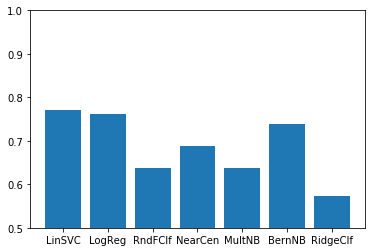

In [105]:
count = range(len(final_scores))
plt.ylim(0.5, 1)
plt.bar(count, np.array(list(final_scores.values())))
plt.xticks(count, list(final_scores.keys()))
plt.show()

---

## Store the best model in a file

In [ ]:
# joblib / pickle
dump(models['?'], 'filename.joblib'?) 

In [ ]:
# model = load('filename.joblib')
# model

In [ ]:
# clf = model[2]
# clf.predict(random_abstracts)

---
### End